In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
# fit a logistic regression model on an imbalanced classification dataset
from sklearn.metrics import r2_score, roc_auc_score, recall_score, precision_score, accuracy_score, mean_squared_error, auc, roc_curve
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats as st
from joblib import dump, load
import pickle
import csv


In [79]:
df_pre = pd.read_csv("formatted_medical7_raw_selection5.csv",header=0, sep="\,")

dc_e = [
    'Graft loss 1 year',
    'AB and Dr mismatch',
    'AKI - KDIGO 2012',
    'Acute RRT initiation',
    'Another urosepsis 1 year',
    'Charlston Comorbidity Index',
    'Donor',
    'FSGS',
    'GCS',
    'Induction',
    'Next UTI - 6 months',
    'Reduction 3--> 2',
    'Reduction to steroid only',
    'Steroid bolus',
    'Transfusion [YES/NO]',
    'Tripple maintenance therapy before admission',
    'Urinary sepsis'
]

dc_c = [
    'Graft loss 1 year',
    'AKI - KDIGO 2012',
    'FSGS',
    'Reduction to steroid only',
    'Transfusion [YES/NO]',
]

# run this to work over samples training set 
from imblearn.over_sampling import SMOTE, ADASYN

df_pre_e = df_pre[dc_e]        
df = df_pre_e.rename(columns={x[1] : "f_{}".format(x[0]) for x in enumerate(df_pre_e.columns)})
oversample = SMOTE()
y_train = df.pop("f_0")
x_train = df
x_data, y_data = oversample.fit_resample(x_train, y_train)
x_train_e, x_test_e, y_train_e, y_test_e = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=True)


# run this to work over raw dataset 
df_pre_c = df_pre[dc_c]        
df = df_pre_c.rename(columns={x[1] : "f_{}".format(x[0]) for x in enumerate(df_pre_c.columns)})
oversample = SMOTE()
y_train = df.pop("f_0")
x_train = df
x_data, y_data = oversample.fit_resample(x_train, y_train)
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=True)


models_dir = "models"
models_evaluation_dir = "models_evaluation"
extended_model_base_dir = os.path.join(models_dir, "extended_models")
extended_model_evaluation_base_dir = os.path.join(models_evaluation_dir, "extended_models")
condensed_model_base_dir = os.path.join(models_dir, "condensed_models")
condensed_model_evaluation_base_dir = os.path.join(models_evaluation_dir, "condensed_models")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [80]:
def train_models(x_train, y_train, x_test, y_test, model_base_path, model_eval_base_path, sampled=True):
    sampled = "sampled" if sampled else "nonsampled"
    #calculate weights
    weights = {x:y for x, y in zip(np.unique(y_train), np.bincount(y_train))}

    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


    #lasso = linear_model.Lasso(alpha=alpha, normalize = False)
    #enet = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False)
    #logr = LogisticRegression(solver='lbfgs', class_weight=weights)

    names = ["Lasso", "Enet", "Loger", "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
            "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
            "Naive Bayes", "QDA"]
    alpha = 0.01
    models = [
        linear_model.Lasso(alpha=alpha, normalize = False),
        linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False),
        LogisticRegression(solver='lbfgs', class_weight=weights),
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]

    trained_models = {}
    threashold = 0.9
    #models = [lasso, enet, logr]
    #names = ["lasso", "enet", "loger"]

    for name, model in zip(names, models):
        # evaluate model
        scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        
        model.fit(x_train, y_train)
        model_path = os.path.join(model_base_path, '{}.joblib'.format(name))
        pickle.dump(
            model, 
            open(model_path, 'wb')
            )
        # discretize predictions
        y_pred = np.where(model.predict(x_test)>threashold,1, 0)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred) 
        precission = precision_score(y_test, y_pred) 
        accuracy = accuracy_score(y_test, y_pred)

        fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test))

        # add model to dictionary
        trained_models[name] = {}
        trained_models[name]["model"] = model
        trained_models[name]["name"] = name
        trained_models[name]["pred"] = model.predict(x_test)
        trained_models[name]["predT"] =y_pred
        trained_models[name]["mse"] = mse
        trained_models[name]["r2"] = r2
        trained_models[name]["roc"] = roc
        trained_models[name]["recall"] = recall
        trained_models[name]["precission"] = precission
        trained_models[name]["accurarcy"] = accuracy
        trained_models[name]["fpr"] = fpr
        trained_models[name]["tpr"] = tpr 
        trained_models[name]["thresholds"] = thresholds

        # summarize performance
        #print('Mean ROC AUC: %.3f' % mean(scores))
        print("Name: {} | ROC: {}, recall: {}, precission: {}, accuracy: {}".format(name, roc, recall, precission, accuracy))

    with open(os.path.join(
        model_eval_base_path, 
        '{}.csv'.format(sampled)), 
        'w', encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)

        # write the header
        writer.writerow(['name', 'mse', 'r2', 'roc', 'recall', 'precission', 'accurarcy'])

        for model in trained_models:
            model_evaluation = trained_models[model]
            row = [
                model_evaluation['name'],
                model_evaluation['mse'],
                model_evaluation['r2'],
                model_evaluation['roc'],
                model_evaluation['recall'],
                model_evaluation['precission'],
                model_evaluation['accurarcy'],
            ]
            # write the data
            writer.writerow(row)

    return trained_models

In [81]:
trained_models_e = train_models(x_train_e, y_train_e, x_test_e, y_test_e, extended_model_base_dir, extended_model_evaluation_base_dir, sampled=True)
trained_models_c = train_models(x_train_c, y_train_c, x_test_c, y_test_c, condensed_model_base_dir, condensed_model_evaluation_base_dir,  sampled=True)

Name: Lasso | ROC: 0.5752146323254946, recall: 0.19298245614035087, precission: 0.8461538461538461, accuracy: 0.5384615384615384
Name: Enet | ROC: 0.583986562150056, recall: 0.21052631578947367, precission: 0.8571428571428571, accuracy: 0.5480769230769231


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Name: Loger | ROC: 0.8234415826801046, recall: 0.8596491228070176, precission: 0.8305084745762712, accuracy: 0.8269230769230769
Name: Nearest Neighbors | ROC: 0.8497573721537888, recall: 0.9122807017543859, precission: 0.8387096774193549, accuracy: 0.8557692307692307
Name: Linear SVM | ROC: 0.7420679357969391, recall: 0.8245614035087719, precission: 0.746031746031746, accuracy: 0.75
Name: RBF SVM | ROC: 0.8208286674132138, recall: 0.6842105263157895, precission: 0.9512195121951219, accuracy: 0.8076923076923077
Name: Gaussian Process | ROC: 0.8409854423292275, recall: 0.8947368421052632, precission: 0.8360655737704918, accuracy: 0.8461538461538461
Name: Decision Tree | ROC: 0.8027248973497574, recall: 0.7543859649122807, precission: 0.86, accuracy: 0.7980769230769231
Name: Random Forest | ROC: 0.8271743187756625, recall: 0.8245614035087719, precission: 0.8545454545454545, accuracy: 0.8269230769230769
Name: Neural Net | ROC: 0.761478163493841, recall: 0.8421052631578947, precission: 0.76

In [37]:
def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])

def kernel(X, Y):
    return .5 if Y==X else int(Y < X)

def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])

def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


# Model A (random) vs. "good" model B
#preds_A = np.array([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5])
#preds_B = np.array([.2, .5, .1, .4, .9, .8, .7, .5, .9, .8])
#actual= np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1])

def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y

def get_p_value(preds_A, preds_B, actual_A, actual_B):
    X_A, Y_A = group_preds_by_label(preds_A, actual_A)
    X_B, Y_B = group_preds_by_label(preds_B, actual_B)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)
    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))
    # Two tailed test
    z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2
    return p


In [51]:
len(trained_models)

13

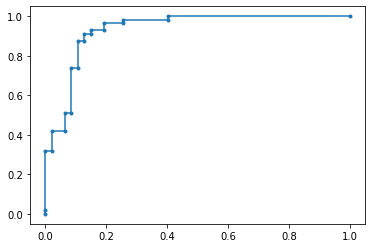

In [34]:
plt.plot(trained_models['enet']['fpr'], trained_models['enet']['tpr'], marker='.', label='Logistic')

In [40]:
def get_p_matrix(trained_models_a, trained_models_b, x_test_a, y_test_a, x_test_b, y_test_b):
    n_models = len(trained_models)
    p_matrix = np.zeros((n_models, n_models))
    for row, model_A in enumerate(trained_models_a):
        preds_A = trained_models_a[model_A]['model'].predict(x_test_a)
        for col, model_B in enumerate(trained_models_b):
            preds_B = trained_models_b[model_B]['model'].predict(x_test_b)
            p_matrix[row][col] = get_p_value(preds_A, preds_B, y_test_a, y_test_b)
    return p_matrix
p_matrix = get_p_matrix(trained_models_e, trained_models_c, x_test_e, y_test_e, x_test_c, y_test_c)

In [107]:
np.savetxt("p_matrix.csv", p_matrix, delimiter = ',')

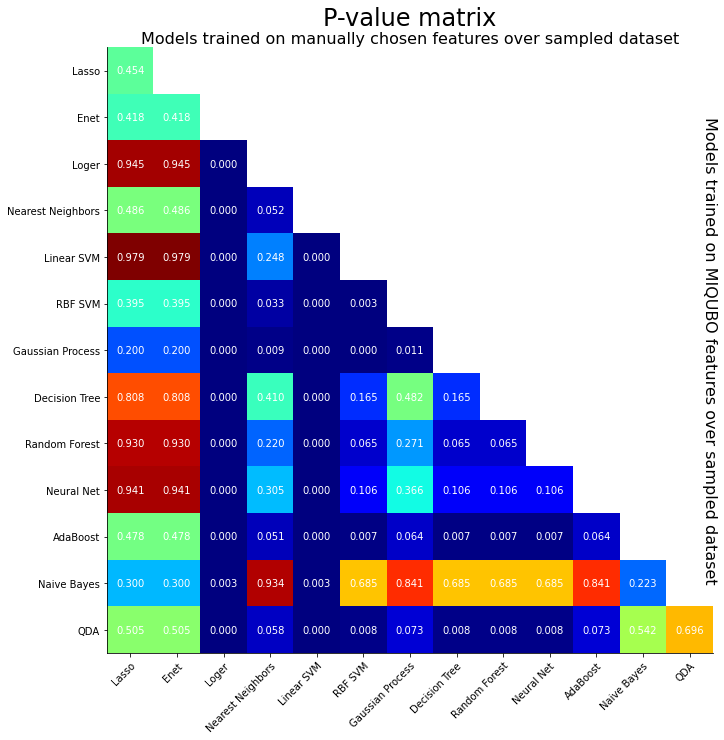

In [88]:
labels = list(trained_models_e.keys())
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

mask = np.zeros((len(labels), len(labels)), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False
lower_traingle_p_matrix = np.ma.array(p_matrix, mask = mask)

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.imshow(lower_traingle_p_matrix, cmap = 'jet')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("P-value matrix", fontsize=24)
ax.set_xticks(x)
ax.set_xlabel("Models trained on manually chosen features over sampled dataset", fontsize=16)
ax.set_yticks(x)
ax.set_ylabel("Models trained on MIQUBO features over sampled dataset", fontsize=16, rotation = -90)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.xaxis.set_label_position("top")
ax.yaxis.set_label_position("right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax2 = ax.twinx()
#ax2.set_ylabel("sth sths th")
# plt.ylabel('sin', color='r')
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
#plt.xticks(rotation=90)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
#plt.ylabel('Your label here', labelpad=-725, fontsize=18)
# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, "%.3f" % p_matrix[i, j],
                       ha="center", va="center", color="w")

plt.savefig("models_evaluation/plots/p_matrix_sampled_sampled.jpg")
plt.show()


In [100]:
mask =  np.tri(len(labels), k=-1)
mask

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [104]:

mask

array([[False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True],
       [False, False, False,

Logistic: ROC AUC=0.931


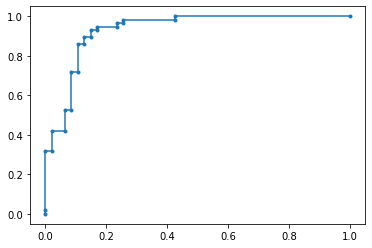

In [30]:
lr_probs = trained_models['lasso']['model'].predict(x_test)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

In [20]:


#calculate weights
weights = {x:y for x, y in zip(np.unique(y_train), np.bincount(y_train))}

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


#lasso = linear_model.Lasso(alpha=alpha, normalize = False)
#enet = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False)
#logr = LogisticRegression(solver='lbfgs', class_weight=weights)

names = ["Lasso", "Enet", "Loger", "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
alpha = 0.01
models = [
    linear_model.Lasso(alpha=alpha, normalize = False),
    linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False),
    LogisticRegression(solver='lbfgs', class_weight=weights),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

trained_models = {}
threashold = 0.9
#models = [lasso, enet, logr]
#names = ["lasso", "enet", "loger"]

for name, model in zip(names, models):
    # evaluate model
    scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    model.fit(x_train, y_train)
    model_path = os.path.join(extended_model_base_dir, '{}.joblib'.format(name))
    pickle.dump(
        model, 
        open(model_path, 'wb')
        )
    # discretize predictions
    y_pred = np.where(model.predict(x_test)>threashold,1, 0)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) 
    precission = precision_score(y_test, y_pred) 
    accuracy = accuracy_score(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test))

    # add model to dictionary
    trained_models[name] = {}
    trained_models[name]["model"] = model
    trained_models[name]["name"] = name
    trained_models[name]["pred"] = model.predict(x_test)
    trained_models[name]["predT"] =y_pred
    trained_models[name]["mse"] = mse
    trained_models[name]["r2"] = r2
    trained_models[name]["roc"] = roc
    trained_models[name]["recall"] = recall
    trained_models[name]["precission"] = precission
    trained_models[name]["accurarcy"] = accuracy
    trained_models[name]["fpr"] = fpr
    trained_models[name]["tpr"] = tpr 
    trained_models[name]["thresholds"] = thresholds
    #trained_models[name]["lr_tpr"] = lr_tpr

    # summarize performance
    print('Mean ROC AUC: %.3f' % mean(scores))
    print("Name: {} | ROC: {}, recall: {}, precission: {}, accuracy: {}".format(name, roc, recall, precission, accuracy))

"""
# define grid
param_grid = dict(class_weight=[{0: weights[0]+i*10, 1 : weights[1]} for i in np.arange(10)])
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute grid serach
grid_result = grid.fit(x_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

"""

array([-2.04582165, -0.13791624, -0.08071423,  2.52203779,  0.74616483,
       -0.90696374, -0.22164773,  1.0142675 , -0.54154924,  0.22661946,
       -0.64635911,  1.37408466,  1.00905314,  0.67411002,  1.53458328,
        0.47971118, -0.91291053,  2.48194524,  0.74236675,  0.23154789])

In [78]:
"""
Its good code do not mess up this
"""
import csv


with open('trained_models_nosampled_4f.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write the header
    writer.writerow(['name', 'mse', 'r2', 'roc', 'recall', 'precission', 'accurarcy'])

    for model in trained_models:
        model_evaluation = trained_models[model]
        row = [
            model_evaluation['name'],
            model_evaluation['mse'],
            model_evaluation['r2'],
            model_evaluation['roc'],
            model_evaluation['recall'],
            model_evaluation['precission'],
            model_evaluation['accurarcy'],

        ]

        # write the data
        writer.writerow(row)

In [8]:
with open('ten pierwszy to jest mse, i z niego wychodzi, ze jak pracujesz na orginalnym datasecie (tz. nie zbalansowanym, tak jak w twoim przypadku), to mse jest nizsze dla wszystkich modeli , 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['name', 'mse', 'r2', 'roc', 'recall', 'precission', 'accurarcy']
['lasso', '0.47115384615384615', '-0.9022023142963786', '0.5683090705487123', '0.15789473684210525', '0.9', '0.5288461538461539']
['enet', '0.4423076923076923', '-0.7857409481149675', '0.5946248600223963', '0.21052631578947367', '0.9230769230769231', '0.5576923076923077']
['loger', '0.14423076923076922', '0.4176931690929453', '0.8516237402015678', '0.8947368421052632', '0.85', '0.8557692307692307']
['Nearest Neighbors', '0.21153846153846154', '0.14594998133631987', '0.7771556550951848', '0.8947368421052632', '0.7611940298507462', '0.7884615384615384']
['Linear SVM', '0.09615384615384616', '0.6117954460619636', '0.8973497573721537', '0.9649122807017544', '0.873015873015873', '0.9038461538461539']
['RBF SVM', '0.5288461538461539', '-1.1351250466592004', '0.5175438596491229', '0.03508771929824561', '1.0', '0.47115384615384615']
['Gaussian Process', '0.09615384615384616', '0.6117954460619636', '0.8992161254199327', '0.947368

In [79]:
no_sample = pd.read_csv('trained_models_nosampled.csv')
sample = pd.read_csv('trained_models_sampled.csv')
sample_4f = pd.read_csv('trained_models_sampled_4f.csv')

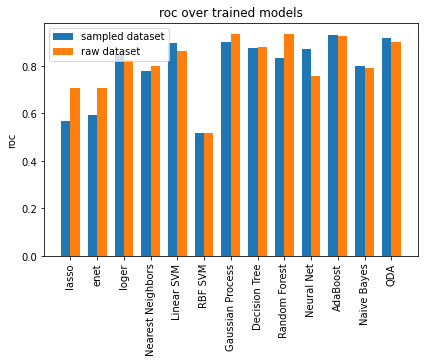

In [83]:
def get_metric_bar_plot(sample, no_sample, metric):
    labels = sample['name']
    mse_sampled = sample[metric]
    mse_nosampled = no_sample[metric]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, mse_sampled, width, label='sampled dataset')
    rects2 = ax.bar(x + width/2, mse_nosampled, width, label='raw dataset')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric)
    ax.set_title("{} over trained models".format(metric))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.xticks(rotation=90)

    plt.show()
get_metric_bar_plot(sample, sample_4f, 'roc') 

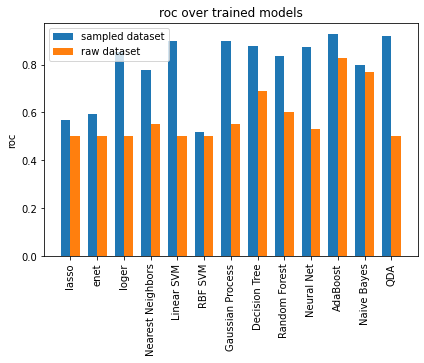

In [68]:
get_metric_bar_plot(sample, no_sample, 'roc') 

In [85]:
sample['roc'] + sample_4f['roc']


0     1.276969
1     1.303285
2     1.676932
3     1.578761
4     1.759612
5     1.035088
6     1.835386
7     1.757745
8     1.768384
9     1.629153
10    1.856663
11    1.591079
12    1.817096
Name: roc, dtype: float64

In [ ]:
import csv


with open('roc_comparision.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write the header
    writer.writerow(['name', 'mse', 'r2', 'roc', 'recall', 'precission', 'accurarcy'])

    for model in trained_models:
        model_evaluation = trained_models[model]
        row = [
            model_evaluation['name'],
            model_evaluation['mse'],
            model_evaluation['r2'],
            model_evaluation['roc'],
            model_evaluation['recall'],
            model_evaluation['precission'],
            model_evaluation['accurarcy'],

        ]

        # write the data
        writer.writerow(row)

In [18]:
for x, y in trained_models.items():
    print("-----------------------------")
    print("Algorithm: {}".format(x))
    print("Evaluation | ROC: {}, Recall: {}, Prec: {}, Acc: {}".format(y["roc"], y["recall"], y["precission"], y["accurarcy"]))
    

-----------------------------
Algorithm: lasso
Evaluation | ROC: 0.5877192982456141, Recall: 0.17543859649122806, Prec: 1.0, Acc: 0.5480769230769231
-----------------------------
Algorithm: enet
Evaluation | ROC: 0.6052631578947368, Recall: 0.21052631578947367, Prec: 1.0, Acc: 0.5673076923076923
-----------------------------
Algorithm: loger
Evaluation | ROC: 0.8747667039940277, Recall: 0.8771929824561403, Prec: 0.8928571428571429, Acc: 0.875
-----------------------------
Algorithm: Nearest Neighbors
Evaluation | ROC: 0.8228816722657708, Recall: 0.9649122807017544, Prec: 0.7857142857142857, Acc: 0.8365384615384616
-----------------------------
Algorithm: Linear SVM
Evaluation | ROC: 0.877939529675252, Recall: 0.9473684210526315, Prec: 0.8571428571428571, Acc: 0.8846153846153846
-----------------------------
Algorithm: RBF SVM
Evaluation | ROC: 0.5087719298245614, Recall: 0.017543859649122806, Prec: 1.0, Acc: 0.46153846153846156
-----------------------------
Algorithm: Gaussian Process


In [33]:
std_ = np.std(trained_models['lasso']['model'].coef_)
mean_ = np.mean(trained_models['lasso']['model'].coef_)
sparsed_results_p = np.where(trained_models['lasso']['model'].coef_ > mean_ + std_, 1, 0)
sparsed_results_n = np.where(trained_models['lasso']['model'].coef_ < mean_ - std_, 1, 0)
sparsed_results = sparsed_results_p + sparsed_results_n

In [43]:
[ x for p, x in zip(sparsed_results, x_train.columns) if p == 1]

['f_8', 'f_9']

<BarContainer object of 26 artists>

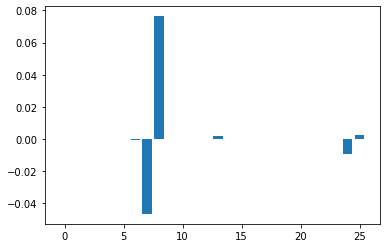

In [50]:
plt.bar(np.arange(26), trained_models['lasso']['model'].coef_)

In [61]:
trained_models['lasso'].keys()

dict_keys(['model', 'name', 'pred', 'predT', 'r2', 'roc', 'recall', 'precission', 'accurarcy'])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


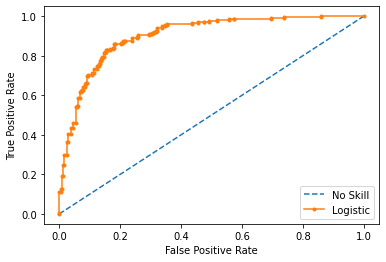

In [5]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [7]:
lr_fpr

array([0.        , 0.        , 0.        , 0.00416667, 0.00416667,
       0.00833333, 0.00833333, 0.0125    , 0.0125    , 0.01666667,
       0.01666667, 0.025     , 0.025     , 0.02916667, 0.02916667,
       0.0375    , 0.0375    , 0.04583333, 0.04583333, 0.05416667,
       0.05416667, 0.05833333, 0.05833333, 0.0625    , 0.0625    ,
       0.06666667, 0.06666667, 0.07083333, 0.07083333, 0.075     ,
       0.075     , 0.07916667, 0.07916667, 0.08333333, 0.08333333,
       0.0875    , 0.0875    , 0.09166667, 0.09166667, 0.09583333,
       0.09583333, 0.10833333, 0.10833333, 0.1125    , 0.1125    ,
       0.125     , 0.125     , 0.12916667, 0.12916667, 0.13333333,
       0.13333333, 0.1375    , 0.1375    , 0.14166667, 0.14166667,
       0.14583333, 0.14583333, 0.15      , 0.15      , 0.15416667,
       0.15416667, 0.15833333, 0.15833333, 0.16666667, 0.16666667,
       0.175     , 0.175     , 0.17916667, 0.17916667, 0.18333333,
       0.18333333, 0.20416667, 0.20416667, 0.20833333, 0.20833

In [55]:
import pickle
file_ = open("trained_models.pkl", "wb")
pickle.dump(trained_models, file_)
file_.close()

In [58]:
import pickle

a_file = open("trained_models.pkl", "rb")
trained_models = pickle.load(a_file)

In [47]:
from sklearn import linear_model
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

alpha = 0.1
lasso = linear_model.Lasso(alpha=alpha, normalize = False)

y_pred_lasso = np.where(lasso.fit(x_train, y_train).predict(x_test)<0,0,1)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
roc_score_lasso = roc_auc_score(y_test, y_pred_lasso)
print(y_pred)
confusion_matrix_lasso = confusion_matrix(y_test, y_pred_lasso) 
print(lasso)
print("roc_auc on test data : %f" % roc_score_lasso)
print("r^2 on test data : %f" % r2_score_lasso)

enet = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False)

y_pred_enet = enet.fit(x_train, y_train).predict(x_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

sum_neg = 0
sum_pos = 0
for x, y in zip(np.where(y_pred_lasso<0, 0, 1), np.where(y_test<0, 0, 1)):
    if x==1 and y ==0:
        sum_pos+=1
    if x==0 and y == 1:
        sum_neg +=1
print("LASSO | SumPos: {}, SumNeg: {}".format(sum_pos, sum_neg))

sum_neg = 0
sum_pos = 0
for x, y in zip(np.where(y_pred_enet<0, 0, 1), np.where(y_test<0, 0, 1)):
    if x==1 and y ==0:
        sum_pos+=1
    if x==0 and y == 1:
        sum_neg +=1
print("ENET | SumPos: {}, SumNeg: {}".format(sum_pos, sum_neg))

[0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0]
Lasso(alpha=0.1)
roc_auc on test data : 0.531250
r^2 on test data : -4.437500
ElasticNet(alpha=0.1, l1_ratio=0.7)
r^2 on test data : 0.092259
LASSO | SumPos: 0, SumNeg: 0
ENET | SumPos: 0, SumNeg: 5


In [50]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

linearly_separable = (x_train, y_train)
pred = {}
# iterate over classifiers
for name, clf in zip(names, classifiers):
    #ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    prediction = clf.fit(x_train, y_train).predict(x_test)
    score = clf.score(x_test, y_test)
    
    y_pred = np.where(prediction>0.9, 1, 0)
    roc_score = roc_auc_score(y_test, y_pred)
    confusion_matrix_score = confusion_matrix(y_test, y_pred)
    pred[name] = {}
    pred[name]["pred"] = prediction
    pred[name]["predT"] = y_pred
    pred[name]["ros"] = roc_score
    pred[name]["cm"] = confusion_matrix_score
    
    print(name)

[0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0]
Nearest Neighbors
[0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0]
Linear SVM
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RBF SVM
[0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0]
Gaussian Process
[0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Decision Tree
[0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Random Forest
[0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
Neural Net
[0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

In [51]:
pred

{'Nearest Neighbors': {'pred': array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]),
  'predT': array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]),
  'ros': 0.675,
  'cm': array([[36, 12],
         [ 4,  6]])},
 'Linear SVM': {'pred': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
  'predT': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
  'ros': 0.6770833333333334,
  'cm': array([[41,  7],
  

In [15]:
np.bincount(y_sam)

array([257, 257])


for x in df.columns:
    if x in dc and list(np.unique(df[x]))==[0,1]:
        df[x] = 2*(2 * df[x]-1)



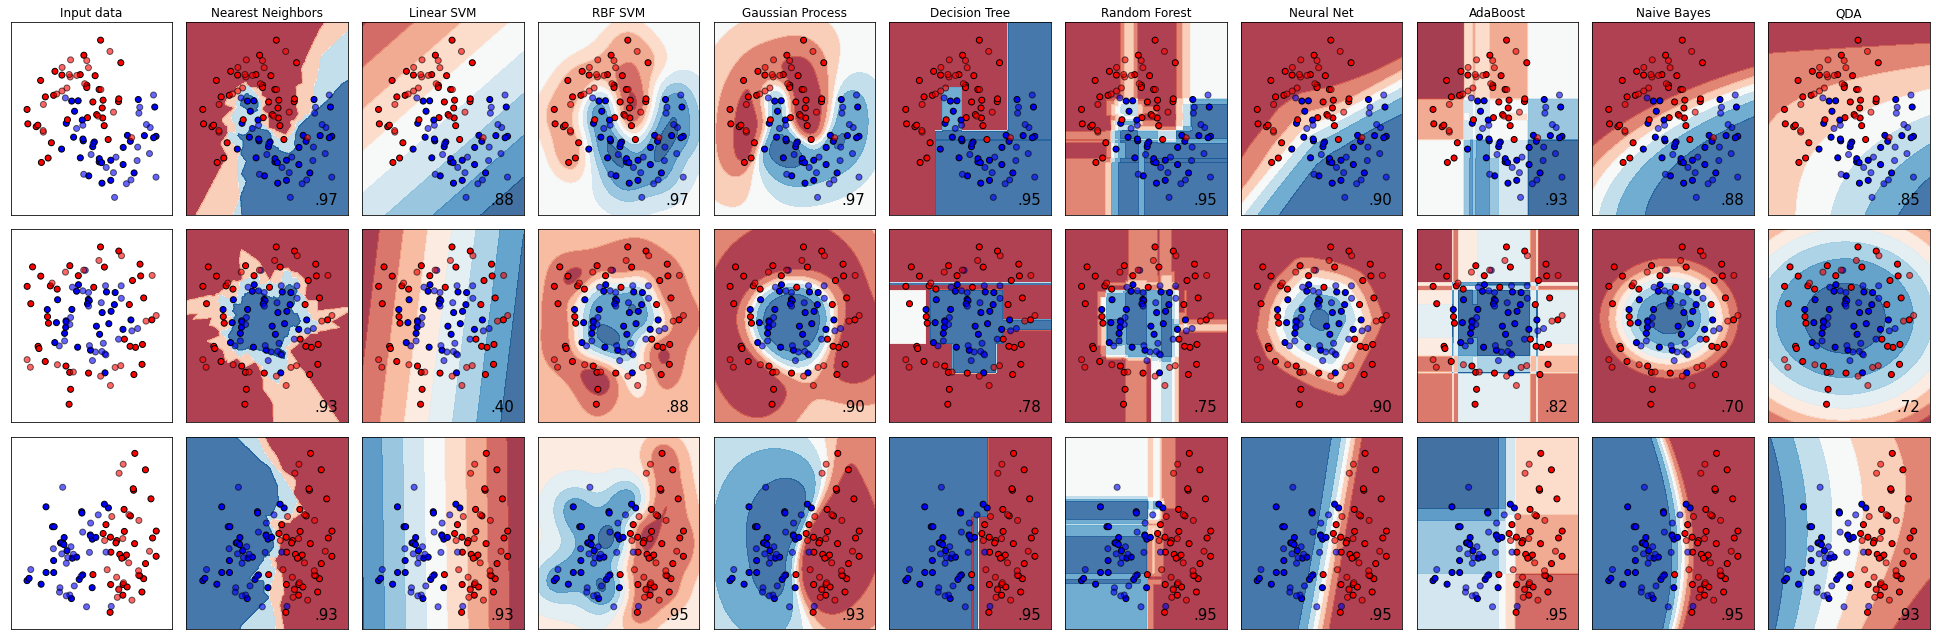

In [32]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()
